# SPCBViTNet – Densenet121 Notebook

📌 Part of the submission titled:  
**"SPCBViTNet: Enhancing Skin Cancer Diagnosis with Multi-Scale Vision Transformers and Adaptive Spatial-Channel Attention"**

📝 This notebook supports reproducibility during peer review.  
🔒 Not yet peer-reviewed. Please do not cite or reuse until publication.

📁 See full repo: [https://github.com/diyagoyal31/SPCBViT](https://github.com/diyagoyal31/SPCBViT)


In [1]:
!nvidia-smi


Mon Mar 10 17:54:57 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070        Off | 00000000:01:00.0  On |                  N/A |
|  0%   56C    P5              33W / 220W |    314MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import sys
print(sys.executable)

/home/praveen/pytorch_env/bin/python3


In [3]:
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

PyTorch Version: 2.6.0+cu124
CUDA Available: True
Device: cuda


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [6]:
# Paths
data_dir = "/home/praveen/Downloads/skin/Preprocessed_HAM10000_224x224_Normalized"
splits_dir = "/home/praveen/Downloads/skin/splits"

In [7]:
# Define classes
class_names = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
num_classes = len(class_names)

In [8]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class HAM10000Dataset(Dataset):
    def __init__(self, csv_file, data_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.data_dir = data_dir  # Store the data directory
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.data.iloc[idx, 1] + ".jpg")  # Use `image_id`
        
        # Load image
        image = Image.open(img_name).convert('RGB')

        # Load label
        label = self.data.iloc[idx, -1]  # Assuming last column is numeric label

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
# Image Transformations
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor()
])

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Define Model Class
class SPCBNet(nn.Module):
    def __init__(self, num_classes):
        super(SPCBNet, self).__init__()
        densenet = models.densenet121(weights="IMAGENET1K_V1")

        # Extract stages from DenseNet
        self.stage1 = densenet.features[:4]   # Initial conv + first dense block
        self.stage2 = densenet.features[4:6]  # Second dense block
        self.stage3 = densenet.features[6:8]  # Third dense block
        self.stage4 = densenet.features[8:]   # Fourth dense block

        # Attention mechanisms
        self.channel_attention = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.Sigmoid()
        )
        
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

        # Fully connected layers
        self.cross_layer = nn.Linear(1024 * 4 * 4, 1024)  # Adjusted input size
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x1 = self.stage1(x)  
        x2 = self.stage2(x1)  
        x3 = self.stage3(x2)  
        x4 = self.stage4(x3)  

        ca = self.channel_attention(x4) * x4
        sa = self.spatial_attention(torch.mean(x4, dim=1, keepdim=True)) * x4
        attention = ca + sa

        pooled_features = F.adaptive_avg_pool2d(attention, (4, 4))
        pooled_features = pooled_features.view(pooled_features.size(0), -1)

        high_order = self.cross_layer(pooled_features)
        output = self.classifier(high_order)

        return output


In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1, fold=0):
    print(f"\n🚀 Training Fold {fold}...\n")
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct, total = 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total * 100
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total * 100
        
        print(f"📅 Epoch [{epoch+1}/{num_epochs}] | 🔥 Train Loss: {train_loss:.4f} | 🎯 Train Acc: {train_acc:.2f}% | 🔍 Val Loss: {val_loss:.4f} | ✅ Val Acc: {val_acc:.2f}%")

    print(f"✅ Training Completed for Fold {fold}\n")


In [12]:
images_dir = "/Dataset/HAM10000"

In [13]:
# 10-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
y_true_all, y_pred_all, y_scores_all = [], [], []
criterion = torch.nn.CrossEntropyLoss()

for fold in range(10):
    train_file = f"splits/fold_{fold}_train.csv"
    val_file = f"splits/fold_{fold}_val.csv"

    # Load datasets for current fold
    train_dataset = HAM10000Dataset(csv_file=train_file, data_dir=images_dir, transform=transform)
    val_dataset = HAM10000Dataset(csv_file=val_file, data_dir=images_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Model Initialization
    model = SPCBNet(num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train for this fold
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, fold=fold)

    
    # Evaluation
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())
    
    y_true_all.extend(y_true)
    y_pred_all.extend(y_pred)
    y_scores_all.extend(y_scores)



🚀 Training Fold 0...

📅 Epoch [1/50] | 🔥 Train Loss: 1.8333 | 🎯 Train Acc: 66.22% | 🔍 Val Loss: 0.7456 | ✅ Val Acc: 72.68%
📅 Epoch [2/50] | 🔥 Train Loss: 0.8401 | 🎯 Train Acc: 70.12% | 🔍 Val Loss: 0.8281 | ✅ Val Acc: 69.83%
📅 Epoch [3/50] | 🔥 Train Loss: 0.7576 | 🎯 Train Acc: 72.36% | 🔍 Val Loss: 0.8132 | ✅ Val Acc: 71.30%
📅 Epoch [4/50] | 🔥 Train Loss: 0.7322 | 🎯 Train Acc: 73.26% | 🔍 Val Loss: 0.7998 | ✅ Val Acc: 72.10%
📅 Epoch [5/50] | 🔥 Train Loss: 0.6925 | 🎯 Train Acc: 74.78% | 🔍 Val Loss: 0.6836 | ✅ Val Acc: 74.63%
📅 Epoch [6/50] | 🔥 Train Loss: 0.7003 | 🎯 Train Acc: 74.61% | 🔍 Val Loss: 0.7166 | ✅ Val Acc: 73.07%
📅 Epoch [7/50] | 🔥 Train Loss: 0.6647 | 🎯 Train Acc: 75.81% | 🔍 Val Loss: 0.6924 | ✅ Val Acc: 74.68%
📅 Epoch [8/50] | 🔥 Train Loss: 0.6520 | 🎯 Train Acc: 76.66% | 🔍 Val Loss: 0.6811 | ✅ Val Acc: 74.38%
📅 Epoch [9/50] | 🔥 Train Loss: 0.6616 | 🎯 Train Acc: 75.98% | 🔍 Val Loss: 0.6682 | ✅ Val Acc: 75.26%
📅 Epoch [10/50] | 🔥 Train Loss: 0.6243 | 🎯 Train Acc: 77.39% | 🔍 Val

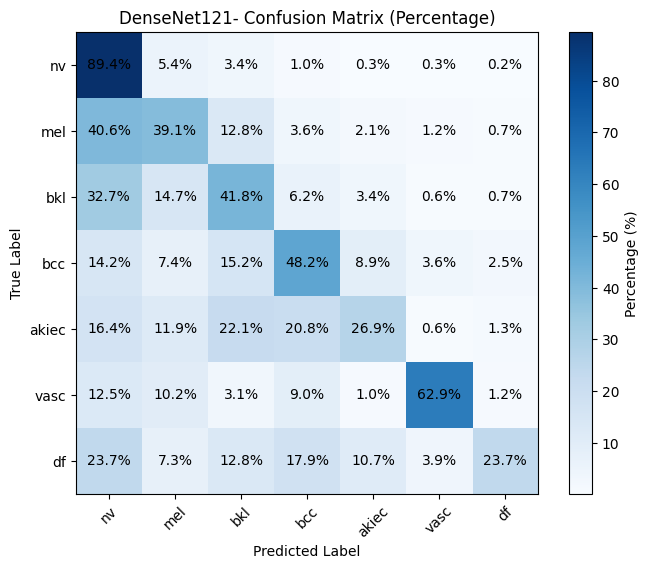

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Normalize by row (percentage of actual class)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True) * 100
conf_matrix_percent = np.nan_to_num(conf_matrix_percent)  # Replace NaN with 0

# Ensure num_classes matches class_names length
num_classes = conf_matrix.shape[0]

if len(class_names) != num_classes:
    print(f"Warning: class_names length ({len(class_names)}) does not match num_classes ({num_classes}).")
    class_names = class_names[:num_classes]  # Fix length mismatch

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_percent, interpolation='nearest', cmap=plt.cm.Blues)
plt.xticks(np.arange(num_classes), class_names, rotation=45)
plt.yticks(np.arange(num_classes), class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.colorbar(label="Percentage (%)")
plt.title('DenseNet121- Confusion Matrix (Percentage)')
 
# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, f"{conf_matrix_percent[i, j]:.1f}%", 
                 ha="center", va="center", color="black")

plt.show()


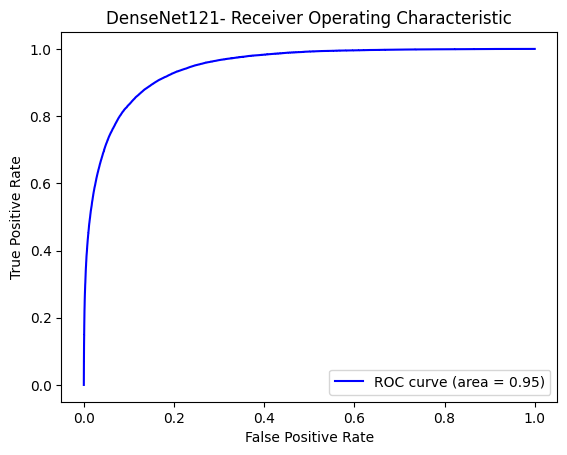

In [15]:
# ROC Curve
y_true_bin = np.eye(num_classes)[y_true_all]
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), np.array(y_scores_all).ravel())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("DenseNet121- Receiver Operating Characteristic")
plt.legend()
plt.show()
